# Advanced Lane Finding Project (Challenge part)

The goals / steps of this project are the following:

* Improve the implementation on original project file ([link](https://github.com/pl80tech/CarND-Advanced-Lane-Finding/blob/master/P2-AdvancedLaneFinding.ipynb))
* Make it worked well with challenge videos

---
# 1) Initial setting & necessary functions (from original project file)

In [1]:
# Importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
%matplotlib inline

In [2]:
# Helper functions
# Show 2 images on the same line for easy comparison
def show2img(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Show 2 images (the second one with gray scale) on the same line for easy comparison
def show2img_gray(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Show 3 images on the same line for easy comparison
def show3img(img1, img2, img3, title1, title2, title3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    ax3.imshow(img3)
    ax3.set_title(title3, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
# Read the matrix (mtx) and coefficients (dist) from calibrated result
# Use the saved data to avoid running the calibration from the beginning when restarting kernel, etc
dist_pickle = pickle.load(open("calibrated_result.bin", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [4]:
# A function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold to generate binary image
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1 
    return grad_binary

# A function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

# A function to return the direction of the gradient
# for a given sobel kernel size and threshold values
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

# A function to threshold an image for a given range of color
def color_thresh(img, color_thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    color_binary = np.zeros_like(gray)
    color_binary[(gray > color_thresh[0]) & (gray <= color_thresh[1])] = 1
    return color_binary

# A function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    hls_binary = np.zeros_like(s_channel)
    hls_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return hls_binary

# A function that thresholds the L-channel of LUV
def luv_select(img, thresh=(0, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    luv_binary = np.zeros_like(l_channel)
    luv_binary[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return luv_binary

# A function that thresholds the B-channel of LAB
def lab_select(img, thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]
    lab_binary = np.zeros_like(b_channel)
    lab_binary[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    return lab_binary

In [5]:
# A function to combine several thresholds
def combined_thresh(img):
    # Generate the binary image for each threshold
    """
    gradx = abs_sobel_thresh(img, orient='x', thresh=(20,100))
    grady = abs_sobel_thresh(img, orient='y', thresh=(20,100))
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_binary = hls_select(img, thresh=(180, 255))
    """
    color_binary = color_thresh(img, color_thresh=(200, 255))
    luv_binary = luv_select(img, thresh=(225, 255))
    lab_binary = lab_select(img, thresh=(155, 200))
    
    # Binary image with combined thresholds
    combined_binary = np.zeros_like(color_binary)
    """
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary[(color_binary == 1) | (hls_binary == 1) | (luv_binary == 1) | (lab_binary == 1)] = 1
    """
    combined_binary[(color_binary == 1) | (luv_binary == 1) | (lab_binary == 1)] = 1
    
    return combined_binary

In [6]:
# Default thresholding method
# 1 : Color threshold (grayscale)
# 2 : HLS S-Channel threshold
# 3 : LUV L-Channel threshold
# 4 : LAB B-Channel threshold
# 5 : Combined threshold
threshold_method = 5

In [7]:
# A function to select method for applying thresholds
def thresh_binary(img):
    if threshold_method == 1:
        binary_image = color_thresh(img, color_thresh=(200, 255))
    elif threshold_method == 2:
        binary_image = hls_select(img, thresh=(180, 255))
    elif threshold_method == 3:
        binary_image = luv_select(img, thresh=(225, 255))
    elif threshold_method == 4:
        binary_image = lab_select(img, thresh=(155, 200))
    elif threshold_method == 5:
        binary_image = combined_thresh(img)

    return binary_image

In [8]:
# A function to perform perspective transform to image from given points (src & dst)
def warped(img, src, dst):
    # Get image size
    img_size = (img.shape[1], img.shape[0])
    # Calculate transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Apply perpective transform with same size as input image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped, M

In [9]:
# Choose reference points for the transform (src & dst)
test_img = mpimg.imread('test_images/test1.jpg')
img_size = (test_img.shape[1], test_img.shape[0])

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

In [10]:
# A function to create histogram of given image
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In [11]:
# A function to find lane pixels from binary warped image
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If the number of detected pixels exceed threshold (minpix), 
        # recenter next window on the mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img

In [12]:
# Option to enable/disable the function showing detected lane pixels & polynomial lines
# True : enable (for easy view when checking test images)
# False : disable (when using the pipeline to generate final video)
for_reference = True

In [13]:
# A function to fit the second order polynomial
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    if leftx.any() and lefty.any():
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        # If no lane pixels are found (rarely happen), use the default values
        # This default value is tuned & taken from a test image (temporary value)
        left_fit = np.array([-5.82876789e-05, 9.89023579e-03, 3.63726419e+02])

    if rightx.any() and rightx.any():
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        # If no lane pixels are found (rarely happen), use the default values
        # This default value is tuned & taken from a test image (temporary value)        
        right_fit = np.array([1.13367624e-04, -3.17551122e-01, 1.14925867e+03])

    # Save the polynomial fit parameters
    lastFrame_save(lane_pickle, "lane_params.p", left_fit, right_fit)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

# A function to search around the polynomial 
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if search_method == 1:
        # Find our lane pixels first (for the first frame)
        leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img_tmp = find_lane_pixels(binary_warped)
        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    elif search_method == 2:
        # Load the saved parameters of last frame
        left_fit, right_fit = lastFrame_load("lane_params.p")
     
        # If no data is saved, create it
        if left_fit.any() == False or right_fit.any() == False:
            # Find lane pixels (for the first frame)
            leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img_tmp = find_lane_pixels(binary_warped)
            # Calculate & save polynomial fit parameters for left & right lane
            left_fitx_tmp, right_fitx_tmp, ploty_tmp = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
            # Load the saved parameters of last frame
            left_fit, right_fit = lastFrame_load("lane_params.p")
        
        # Set the area of search based on activated x-values
        # within the +/- margin of our polynomial function
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
        # Temporary fix
        left_ave = np.average(left_fitx)
        right_ave = np.average(right_fitx)
        diff_ave = right_ave - left_ave
    
        if (diff_ave < 680) or (diff_ave > 820) or (left_ave > 1280) or (right_ave > 1280):
            # The detected lane lines are not suitable. Need to detect by other way
            # Find lane pixels
            leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img_tmp = find_lane_pixels(binary_warped)
            # Calculate & save polynomial fit parameters for left & right lane
            left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Change margin to smaller value to display the lane lines
    # Still keep big margin when searching for high accuracy
    margin = 30    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    if for_reference:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    else:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*0
    window_img = np.zeros_like(out_img)
    
    if for_reference:
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0,0,255]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Define the middle area between detected lane lines
    middle_area = np.hstack((left_line_window2, right_line_window1))
    # Fill middle area with color Green
    cv2.fillPoly(window_img, np.int_([middle_area]), (0, 255, 0))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,0,0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if for_reference:
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    ## End visualization steps ##
    
    return result, ploty, left_fitx, right_fitx

In [14]:
# Pickle to keep lane line parameters of last frame
lane_pickle = {}

In [15]:
# A function to initialize the parameters of last frame to empty array
# Parameters : coefficients for left & right lane
def lastFrame_init(lane_pickle, filepath):
    lane_pickle["left_fit"] = np.array([])
    lane_pickle["right_fit"] = np.array([])
    pickle.dump(lane_pickle, open(filepath,"wb"))

# A function to save the parameters of last frame
# Parameters : coefficients for left & right lane
def lastFrame_save(lane_pickle, filepath, left_fit, right_fit):
    lane_pickle["left_fit"] = left_fit
    lane_pickle["right_fit"] = right_fit
    pickle.dump(lane_pickle, open(filepath,"wb"))

# A function to load the parameters of last frame
# Parameters : coefficients for left & right lane
def lastFrame_load(filepath):
    lane_pickle = pickle.load(open(filepath,"rb"))
    left_fit = lane_pickle["left_fit"]
    right_fit = lane_pickle["right_fit"]
    return left_fit, right_fit

In [16]:
# A helper function to combine the generated binary image with initial image
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img`: output image of the process    
    `initial_img`: the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [17]:
# A function to add culvature radius and distance from center to image
def add_radius_distance(img, radius, distance):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, "Radius of curvature = %.0fm" % radius, (50, 50), font, 2, (255,0,0), thickness=2)
    if distance < 0:
        cv2.putText(img, "Vehicle is %.2fm right of center" % np.abs(distance), (50, 120), font, 2, (255,0,0), thickness=2)
    else:
        cv2.putText(img, "Vehicle is %.2fm left of center" % distance, (50, 120), font, 2, (255,0,0), thickness=2)

In [18]:
# A function to calculate culvature radius and relative position from lane coordinates
def measure_curvature_radius_position(ploty, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions and distance from center in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty) * ym_per_pix
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    radius = (left_curverad + right_curverad)/2

    # Calculate the position of left line & right lane nearest to the camera
    left_pos = left_fit_cr[0]*(y_eval**2) + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_pos = right_fit_cr[0]*(y_eval**2) + right_fit_cr[1]*y_eval + right_fit_cr[2]
    
    # Position of the center of the 2 lanes in the image
    position = (left_pos + right_pos)/2

    # Distance from the center of the image
    # Assuming here that image.shape[1] = 1280
    distance_from_center = position - (1280/2)*xm_per_pix 
    
    return radius, distance_from_center

# 2) Pipeline to process with video

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
# Show targeted videos in a line (for easy confirmation)
HTML("""<video width="320" height="180" title="Project video" controls> 
<source src="project_video.mp4">
</video>
<video width="320" height="180" title="Challenge video" controls> 
<source src="challenge_video.mp4">
</video>
<video width="320" height="180" title="Harder challenge video" controls> 
<source src="harder_challenge_video.mp4">
</video>""")

In [21]:
# Pipepline to process each image
def process_image(img):
    # Undistort the given image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Create binary image by applying thresholds
    binary = thresh_binary(undist)
    
    # Create a warped image by perspective transform
    binary_warped, M_perspective = warped(binary, src, dst)
    
    # Search method 1 & 2
    if search_method == 1 or search_method == 2:      
        # Call the process to search & draw the lane lines
        boundary, ploty, left_fitx, right_fitx = search_around_poly(binary_warped)
    # Search method 3
    else:
        # Apply the search pipepline to binary image
        boundary = convolution_search(binary_warped)
    
    # Calculate the actual radius of curvature and distance from center in meters
    radius, distance_from_center = measure_curvature_radius_position(ploty, left_fitx, right_fitx)
    
    # Unwarped the binary image
    # Apply perspective transform reversely by switching src & dst
    binary_unwarped, M_perspective_reverse = warped(boundary, dst, src)
    
    # Warp the detected lane boundaries back onto the original image
    result = weighted_img(undist,binary_unwarped)
    
    # Fill the curvature information in targeted image
    add_radius_distance(result, radius, distance_from_center)
    
    return result

In [22]:
# Option to enable/disable the function showing detected lane pixels & polynomial lines
# True : enable (for easy view when checking test images)
# False : disable (when using the pipeline to generate final video)
for_reference = False

In [23]:
# Select the search method before processing the pipeline
# 1 : process each frame separately to find lane pixels & fit a polynomial
# 2 : use the parameters from last frame to search lane pixels & fit a polynomial 
# 3 : use convolution search (not fully supported for processing video yet)
search_method = 2

In [24]:
# Initialize before processing the pipeline 
lastFrame_init(lane_pickle, "lane_params.p")

# Apply the pipeline to process project video
# Firstly try with the first 10s
# project_video = VideoFileClip("project_video.mp4").subclip(0,10)
# Then try with full video
project_video = VideoFileClip("project_video.mp4")
project_video_output = 'output_videos/project_video_output.mp4'
project_video_process = project_video.fl_image(process_image)
%time project_video_process.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [02:20<00:00,  8.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 4min 7s, sys: 5.12 s, total: 4min 12s
Wall time: 2min 22s


In [25]:
# Show 2 videos (original & with search method 2) in a line for easy comparison
HTML("""<video width="480" height="270" title="Output video - method 1" controls> 
<source src="project_video.mp4">
</video>
<video width="480" height="270" title="Output video - method 2" controls> 
<source src="output_videos/project_video_output.mp4">
</video>""")

## 3) Apply the pipeline to process with challenge videos to find the shortcomings

In [26]:
# Initialize before processing the pipeline 
lastFrame_init(lane_pickle, "lane_params.p")

# Apply the pipeline to challenge video
# Firstly try with the first 10s
# challenge_video = VideoFileClip("challenge_video.mp4").subclip(0,10)
# Then try with full video
challenge_video = VideoFileClip("challenge_video.mp4")
challenge_video_output = 'output_videos/challenge_video_output.mp4'
challenge_video_process = challenge_video.fl_image(process_image)
%time challenge_video_process.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_output.mp4
[MoviePy] Writing video output_videos/challenge_video_output.mp4


100%|██████████| 485/485 [00:53<00:00,  9.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_output.mp4 

CPU times: user 1min 34s, sys: 1.93 s, total: 1min 36s
Wall time: 54.9 s


In [27]:
# Show 2 videos (before and after) in a line for easy comparison
HTML("""<video width="480" height="270" title="Challenge video" controls> 
<source src="challenge_video.mp4">
</video>
<video width="480" height="270" title="Output video" controls> 
<source src="output_videos/challenge_video_output.mp4">
</video>""")

In [28]:
# Initialize before processing the pipeline 
lastFrame_init(lane_pickle, "lane_params.p")

# Apply the pipeline to challenge video
# Firstly try with the first 10s
# harder_challenge_video = VideoFileClip("harder_challenge_video.mp4").subclip(0,10)
# Then try with full video
harder_challenge_video = VideoFileClip("harder_challenge_video.mp4")
harder_challenge_video_output = 'output_videos/harder_challenge_video_output.mp4'
harder_challenge_video_process = harder_challenge_video.fl_image(process_image)
%time harder_challenge_video_process.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video_output.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:59<00:00,  7.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_output.mp4 

CPU times: user 4min 34s, sys: 6.1 s, total: 4min 40s
Wall time: 3min 1s


In [29]:
# Show 2 videos (before and after) in a line for easy comparison
HTML("""<video width="480" height="270" title="Harder challenge video" controls> 
<source src="harder_challenge_video.mp4">
</video>
<video width="480" height="270" title="Output video" controls> 
<source src="output_videos/harder_challenge_video_output.mp4">
</video>""")

## 4) Just for checking the performance on difficult frame for further improvement

In [30]:
# Load the targeted clip
debug_video = VideoFileClip("project_video.mp4")
# Pick an image/frame from the clip for further analysis
# Frame at 41.8s has heavy shadow
debug_img = debug_video.get_frame(41.8)
print('This image is:', type(debug_img), 'with dimensions:', debug_img.shape)

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


In [31]:
# Undistort targeted image
debug_img_undist = cv2.undistort(debug_img, mtx, dist, None, mtx)

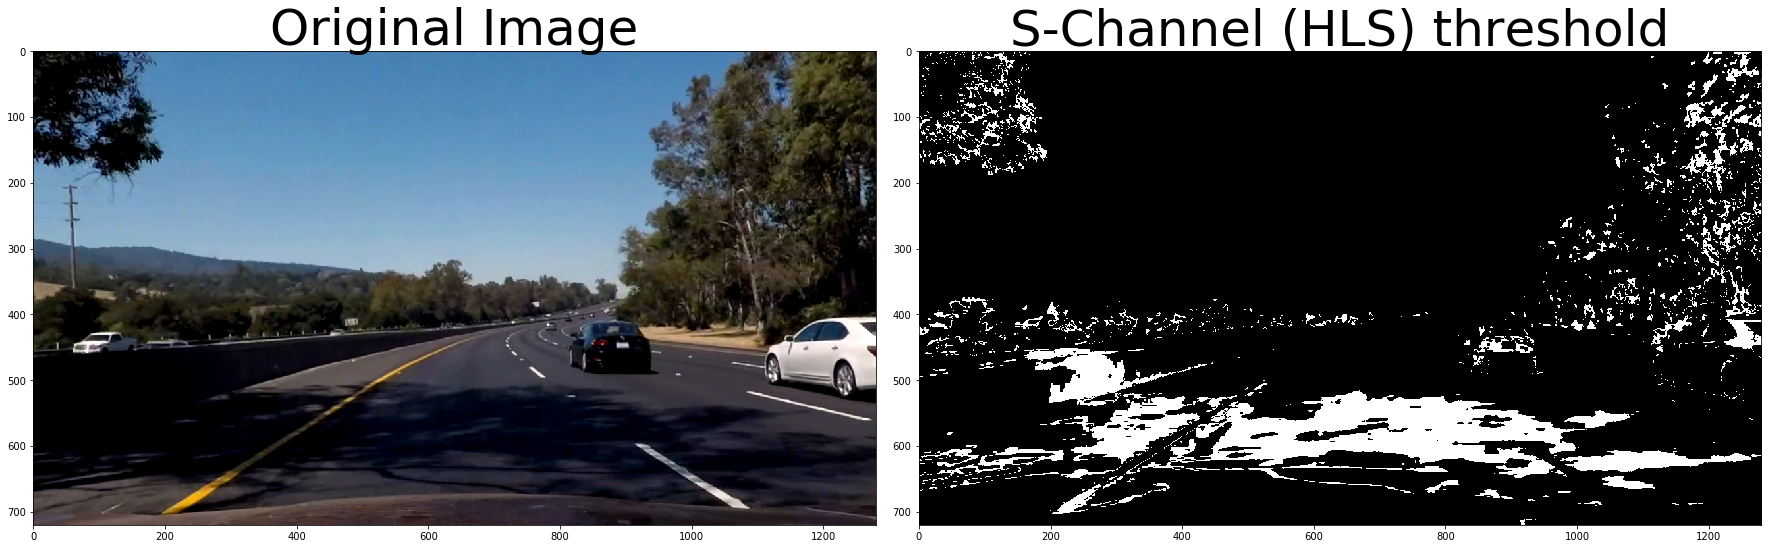

In [32]:
# Specify the thresholding method
threshold_method = 2
# Check the thresholded binary image
debug_img_binary = thresh_binary(debug_img_undist)
show2img_gray(debug_img_undist, debug_img_binary, "Original Image", "S-Channel (HLS) threshold")

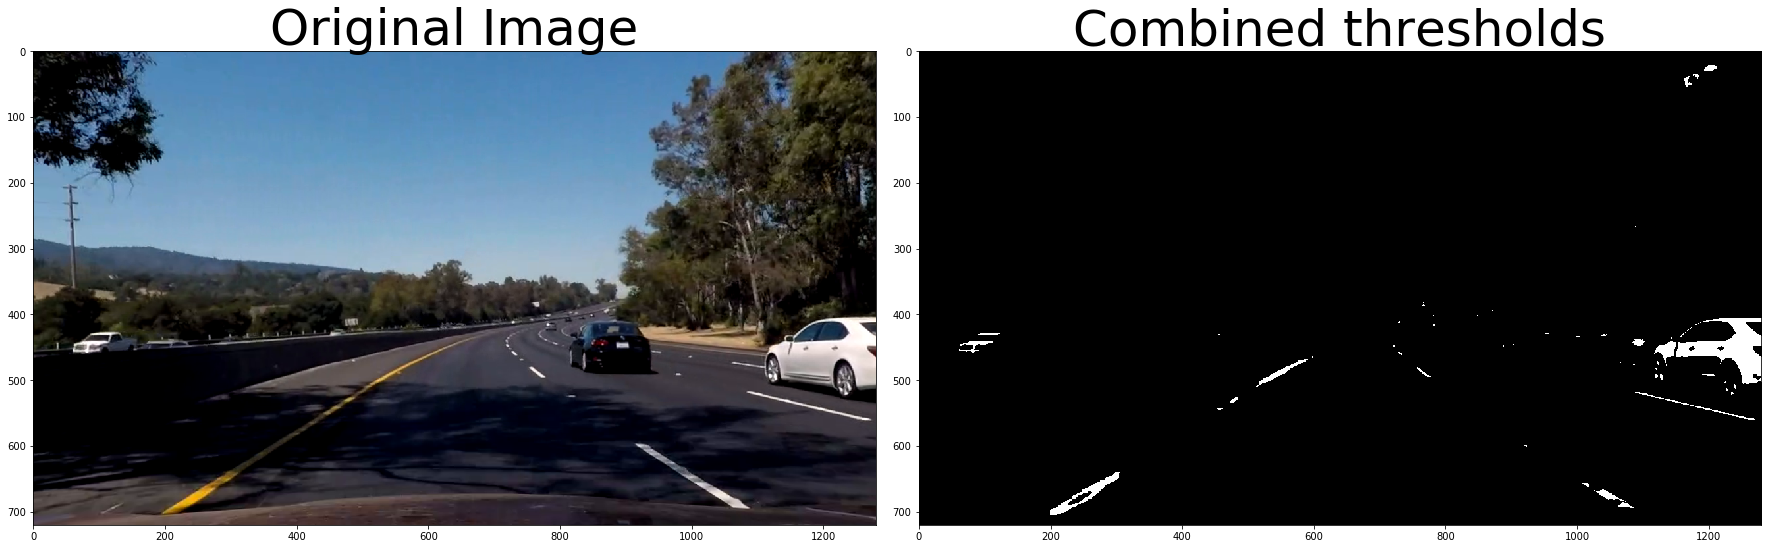

In [33]:
# Specify the thresholding method
threshold_method = 5
# Check the thresholded binary image
debug_img_binary_1 = thresh_binary(debug_img_undist)
show2img_gray(debug_img_undist, debug_img_binary_1, "Original Image", "Combined thresholds")

In [34]:
# Call the pipeline to process the image
threshold_method = 5
lastFrame_init(lane_pickle, "lane_params.p")
processed_debug_img = process_image(debug_img_undist)

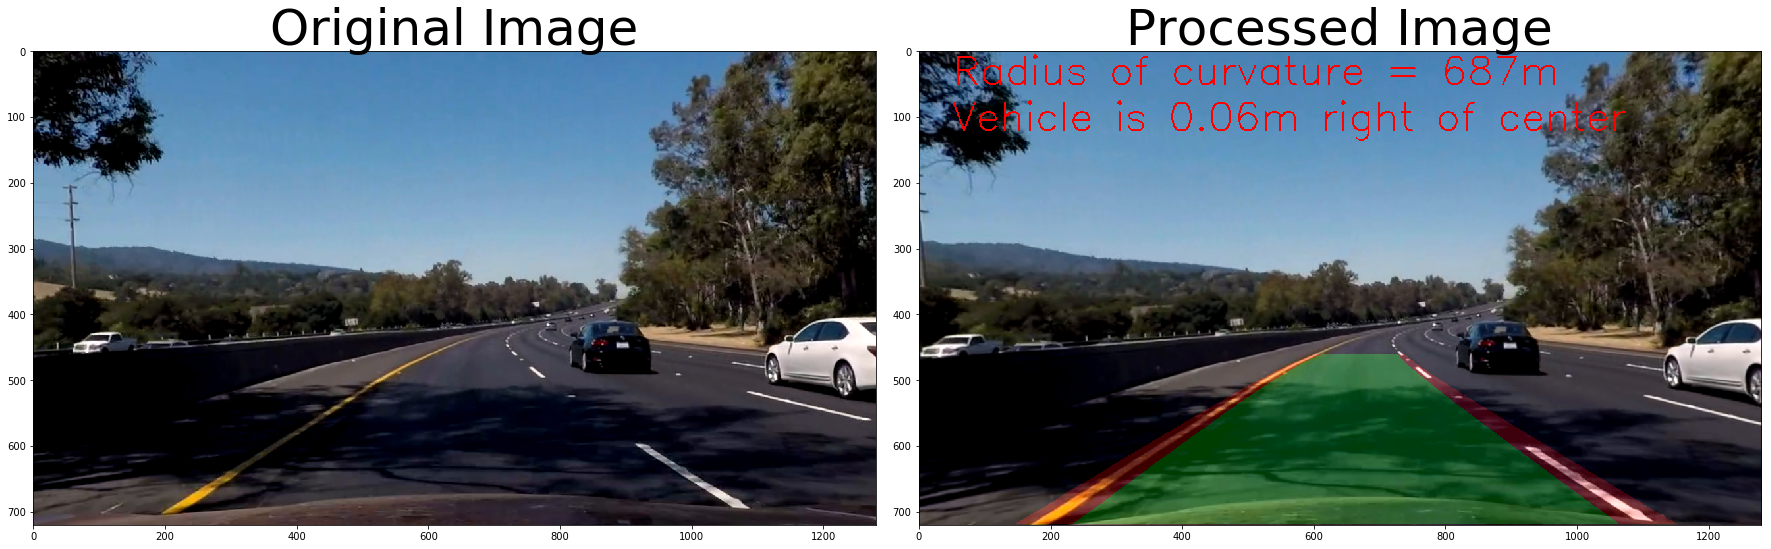

In [35]:
# Show 2 images (original & processed image)
show2img_gray(debug_img_undist, processed_debug_img, "Original Image", "Processed Image")